In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings

## Load data

In [2]:
df = pd.read_csv('data/18-Total_Renewable_Energy_Consumption_Annual.csv',skiprows=4,index_col='Year',parse_dates=True)
df.columns = ['total-renewable-energy']
df = df.sort_index()
df.head()

,total-renewable-energy
Year,
1949-01-01,2973.984
1950-01-01,2977.718
1951-01-01,2958.464
1952-01-01,2940.181
1953-01-01,2831.460


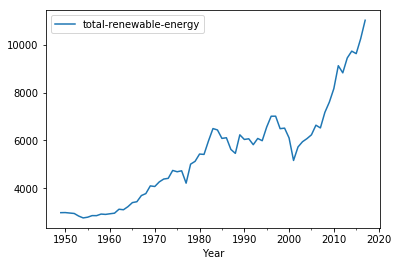

In [3]:
df.plot()

## stationary check

In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):           
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
test_stationarity(df['total-renewable-energy'])

Results of Dickey-Fuller Test:
Test Statistic                  1.619656
p-value                         0.997915
#Lags Used                      0.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


**df['total-primary-energy'] is not stationary**

In [6]:
df['total_diff'] = df['total-renewable-energy'].diff()
df.head()

,total-renewable-energy,total_diff
Year,,
1949-01-01,2973.984,NaN
1950-01-01,2977.718,3.734
1951-01-01,2958.464,-19.254
1952-01-01,2940.181,-18.283
1953-01-01,2831.460,-108.721


In [7]:
test_stationarity(df['total_diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.679558e+00
p-value                        1.516691e-11
#Lags Used                     0.000000e+00
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


**df['total_diff'] is stationary series**

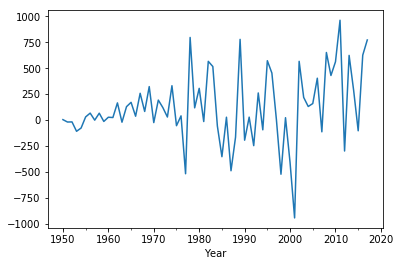

In [8]:
df['total_diff'].plot()

## Decomposition

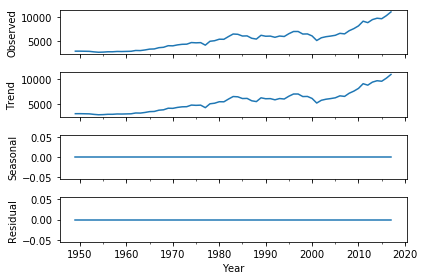

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df['total-renewable-energy']).plot()
plt.show()

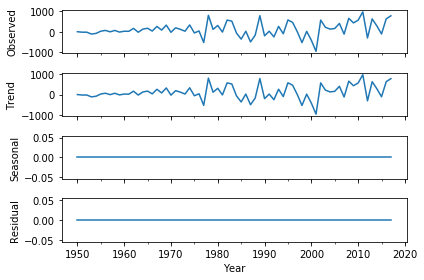

In [10]:
seasonal_decompose(df['total_diff'].dropna()).plot()
plt.show()

### ACF and PACF plots:

In [11]:
from statsmodels.tsa.stattools import acf, pacf

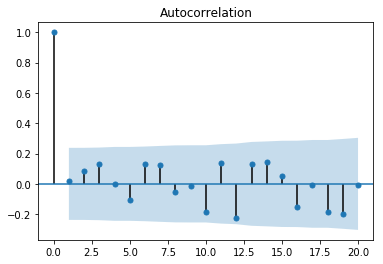

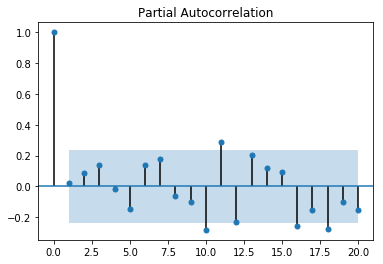

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['total_diff'].dropna(),lags=20)
plot_pacf(df['total_diff'].dropna(),lags=20)
plt.show()

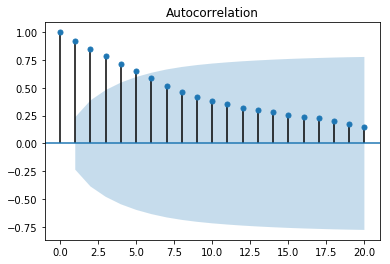

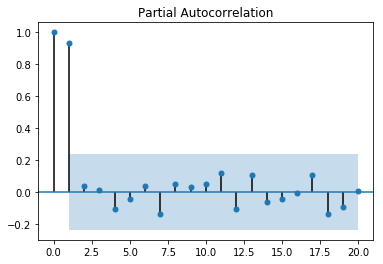

In [13]:
plot_acf(df['total-renewable-energy'],lags=20)
plot_pacf(df['total-renewable-energy'],lags=20)
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 1949-01-01 to 2017-01-01
Data columns (total 2 columns):
total-renewable-energy    69 non-null float64
total_diff                68 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


## Split data

In [15]:
train = pd.DataFrame(df['total-renewable-energy'][:41])
valid = pd.DataFrame(df['total-renewable-energy'][41:55])
test  = pd.DataFrame(df['total-renewable-energy'][55:])

In [16]:
train.shape

(41, 1)

In [17]:
valid.shape

(14, 1)

In [18]:
test.shape

(14, 1)

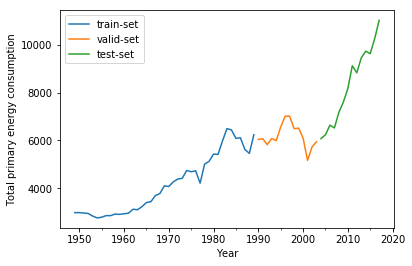

In [19]:
ax1 = train.plot()
valid.plot(ax=ax1)
test.plot(ax=ax1)
plt.legend(['train-set','valid-set','test-set'])
plt.ylabel('Total primary energy consumption')
plt.show()

## ARIMA model

In [20]:
from statsmodels.tsa.arima_model import ARIMA
# Forecasting a simulated model

In [21]:
warnings.filterwarnings("ignore")
i=0
for p in range(4):
    for d in range(4):
        for q in range(4): 
            try:
                model = ARIMA(train, order=(p,d,q))
                result = model.fit()
                print(i,p,d,q,result.aic,result.bic)
                i=i+1
            except:
                continue
            

0 0 0 0 703.0597483805037 706.4868925139124
1 0 0 1 664.1363171675324 669.2770333676453
2 0 0 2 633.7493512186963 640.6036394855136
3 0 0 3 621.6831581829798 630.2510185165014
4 0 1 0 563.4840243259644 566.8617832341922
5 0 1 1 565.1918613101618 570.2584996725036
6 0 1 2 567.1890976958327 573.9446155122885
7 0 1 3 568.1394948056363 576.583892076206
8 0 2 0 577.0153176376996 580.3424409299589
9 0 2 1 555.2666069335926 560.2572918719816
10 0 2 2 557.1024213215309 563.7566679060494
11 1 0 0 586.3445942276683 591.4853104277812
12 1 0 2 590.0619507309932 598.6298110645148
13 1 0 3 592.0589787153957 602.3404111156216
14 1 1 0 565.1928846026697 570.2595229650115
15 1 1 1 565.6582789102536 572.4137967267093
16 1 2 0 567.5270738085122 572.5177587469011
17 1 2 1 557.0975479917342 563.7517945762528
18 1 2 3 560.895564161286 570.8769340380638
19 2 0 0 588.3445700330674 595.1988582998846
20 2 0 1 586.6140473529806 595.1819076865022
21 2 1 0 567.1919740467829 573.9474918632386
22 2 1 1 567.656883419

**Minimum of AIC or BIC is at (p,d,q) = (0,2,1)**

In [22]:
model1 = ARIMA(train, order=(0,2,1))
result1 = model1.fit()
print(result1.summary())
print("μ={} ,ϕ={}".format(result1.params[0],result1.params[1]))

                                 ARIMA Model Results                                 
Dep. Variable:     D2.total-renewable-energy   No. Observations:                   39
Model:                        ARIMA(0, 2, 1)   Log Likelihood                -274.633
Method:                              css-mle   S.D. of innovations            263.920
Date:                       Mon, 10 Dec 2018   AIC                            555.267
Time:                               20:46:36   BIC                            560.257
Sample:                           01-01-1951   HQIC                           557.057
                                - 01-01-1989                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               3.4621      3.615      0.958      0.344      -3.623      10.547
ma.L1.D2.tot

[]

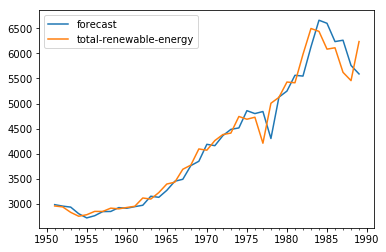

In [23]:
result1.plot_predict()
plt.plot()

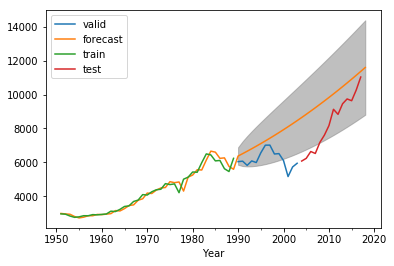

In [24]:
ax1 = valid.plot()
result1.plot_predict(2,69,ax=ax1)
test.plot(ax=ax1)
plt.legend(['valid','forecast','train','test'])
plt.show()

In [25]:
result1.conf_int()

,0,1
const,-3.623149,10.547428
ma.L1.D2.total-renewable-energy,-1.144500,-0.855500


**This model is fitted well for train set.
But it does not predict well for valid and test set**

In [30]:
#result1.predict(2,75)